In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
from PIL import Image
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import time
import argparse

from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [2]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [3]:
height = 512
width = 512

content_img_path = 'GirlWithoutScarf.jpeg'
content_img = Image.open(content_img_path)
content_img = content_img.resize((width, height))                  

In [4]:
style_img_path = 'sunset.jpg'
style_img = Image.open(style_img_path)
style_img = style_img.resize((width, height))

In [5]:
content_arr = np.asarray(content_img, dtype='float32')
content_arr = np.expand_dims(content_arr, axis=0)

style_arr = np.asarray(style_img, dtype='float32')
style_arr = np.expand_dims(style_arr, axis=0)

In [6]:
#preprocess as per Simoyan (2015)
content_arr[:, :, :, 0] -= 103.939
content_arr[:, :, :, 1] -= 116.779
content_arr[:, :, :, 2] -= 123.68
content_arr = content_arr[:, :, :, ::-1]

style_arr[:, :, :, 0] -= 103.939
style_arr[:, :, :, 1] -= 116.779
style_arr[:, :, :, 2] -= 123.68
style_arr = style_arr[:, :, :, ::-1]

In [7]:
base_image = K.variable(content_arr)
style_image = K.variable(style_arr)
output_image = K.placeholder((1, height, width, 3))

In [8]:
input_tensor = K.concatenate([base_image, style_image, output_image], axis=0)

In [9]:
from keras.applications.vgg16 import VGG16
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [10]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [11]:
loss = K.variable(0.)

In [12]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [13]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [15]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(output_image)

In [16]:
grads = K.gradients(loss, output_image)

In [17]:
outputs = [loss]
outputs += grads
f_outputs = K.function([output_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [18]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 119921400000.0
Iteration 0 completed in 521s
Start of iteration 1
Current loss value: 52761686000.0
Iteration 1 completed in 505s
Start of iteration 2
Current loss value: 34542686000.0
Iteration 2 completed in 482s
Start of iteration 3
Current loss value: 30030217000.0
Iteration 3 completed in 484s
Start of iteration 4
Current loss value: 28054936000.0
Iteration 4 completed in 476s
Start of iteration 5
Current loss value: 26900025000.0
Iteration 5 completed in 528s
Start of iteration 6
Current loss value: 26028972000.0
Iteration 6 completed in 448s
Start of iteration 7
Current loss value: 25555677000.0
Iteration 7 completed in 421s
Start of iteration 8
Current loss value: 25160430000.0
Iteration 8 completed in 374s
Start of iteration 9
Current loss value: 24808993000.0
Iteration 9 completed in 416s


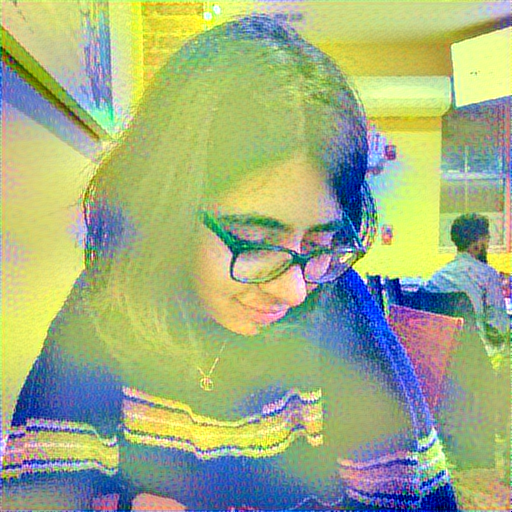

In [19]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)